<a href="https://colab.research.google.com/github/NikNord174/GAN_sandbox/blob/main/cGAN_Galaxis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#cGAN generated new galaxis 

In [1]:
!pip install astronn -q

In [2]:
from astroNN.datasets import load_galaxy10
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
images, labels = load_galaxy10()

WARNING! APOGEE environment variable SDSS_LOCAL_SAS_MIRROR not set
WARNING! Gaia environment variable GAIA_TOOLS_DATA not set
/root/.astroNN/datasets/Galaxy10.h5 was found!


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, RandomRotation, Resize
import PIL

class GalaxyDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images[:int(images.shape[0]/5)]
        self.labels = labels
        self.transform = Compose([RandomRotation(degrees=(-179, 179)),
                                  ToTensor()
                                  ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, indx):
        image = PIL.Image.fromarray(self.images[indx])
        image = self.transform(image)
        label = self.labels[indx]
        return image, label

galaxy = GalaxyDataset(images, labels)

In [4]:
import numpy as np

cl_indx = [] # indexes
for i in range(0,10): # for each class(10)
    for num, sample in enumerate(galaxy): 
        if sample[1] == i:
            cl_indx.append(num)
            break

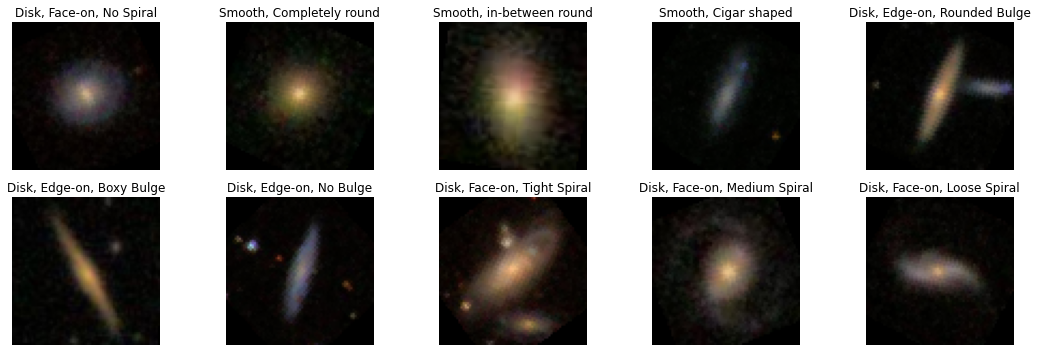

In [5]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(nrows=2, ncols=5, figsize=(15,5))
for num, indx in enumerate(cl_indx):
    if num < 5:
        row=0
    else:
        row=1
        num -= 5
    ax[row,num].imshow(galaxy[indx][0].permute(1,2,0))
    ax[row,num].set_title(galaxy10cls_lookup(galaxy[indx][1]))
    ax[row,num].axis('off')

plt.tight_layout()

In [6]:
image_shape=(3,69,69)
n_classes=10
embedding_dim=3
latent_dim=100

batch_size = 8
num_classes = 10

n_epochs = 50
lr = 0.02
b1=0.5
b2=0.999

In [7]:
train_loader=DataLoader(dataset=galaxy, batch_size=batch_size, shuffle=True)

In [8]:
from torch import nn
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.image_shape=image_shape

        self.embedding=nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                nn.Linear(embedding_dim,4*4))
        
        self.latent=nn.Sequential(nn.Linear(latent_dim,8192),
                                   nn.ReLU())

        self.model = nn.Sequential(nn.ConvTranspose2d(in_channels=513, 
                              out_channels=64*8,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*8),
                      nn.ReLU(),

                      nn.ConvTranspose2d(in_channels=64*8, 
                              out_channels=64*8,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*8),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*8, 
                              out_channels=64*8,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*8),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*8, 
                              out_channels=64*4,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*4),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*4, 
                              out_channels=64*2,
                              kernel_size=4,
                              stride=2,
                              padding=1,),
                      nn.BatchNorm2d(64*2),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*2, 
                              out_channels=64*1,
                              kernel_size=4,
                              stride=2,
                              padding=60,),
                      nn.BatchNorm2d(64*1),
                      nn.ReLU(),
                      
                      nn.ConvTranspose2d(in_channels=64*1, 
                              out_channels=3,
                              kernel_size=4,
                              stride=1,
                              padding=36,
                              dilation=1),
                      nn.Tanh())

    def forward(self, inputs):
      noise_vector,labels=inputs
      latent_output = self.latent(noise_vector)
      latent_output=latent_output.view(-1,512,4,4)
      labels=torch.tensor(labels).long()
      labels_output=self.embedding(labels)
      labels_output=labels_output.view(-1,1,4,4)
      output=torch.cat((latent_output,labels_output),dim=1)
      image = self.model(output)
      return image

In [9]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.embedding=nn.Sequential(
        nn.Embedding(n_classes, embedding_dim)
        )
    
    self.model=nn.Sequential(nn.Conv2d(3,64,4,2,1,bias=False),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,64*2,4,2,1,bias=False),
            nn.BatchNorm2d(64*2, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*2,64*4,4,2,1,bias=False),
            nn.BatchNorm2d(64*4, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64*4,64*8,4,2,1,bias=False),
            nn.BatchNorm2d(64*8, momentum=0.1, eps=0.8),
            nn.LeakyReLU(0.2, inplace=True))
    
    self.linear_model=nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.7),
            nn.Linear(8195,1),
            nn.Sigmoid())
    

  def forward(self, inputs):
      image,label=inputs

      label=torch.tensor(label).long()
      label_output=self.embedding(label)
      image = self.model(image)
      image=image.view(image.size(0),-1)
      output=torch.cat((image,label_output),dim=1)
      image = self.linear_model(output)
      return image

In [10]:
adversarial_loss=nn.BCELoss()

def generator_loss(fake_output,label):
  gen_loss=adversarial_loss(fake_output,label)
  return gen_loss

def discriminator_loss(output,label):
  disc_loss=adversarial_loss(output,label)
  return disc_loss

In [11]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))

In [12]:
def train(generator, discriminator, 
          D_optimizer, G_optimizer,
          train_loader,
          n_epochs,
          device):

    D_loss_plot=[]
    G_loss_plot=[]

    for epoch in range(1,n_epochs+1):
      D_loss_list=[]
      G_loss_list=[]

      for index, (real_images, labels) in enumerate(train_loader):
        D_optimizer.zero_grad()
        
        real_images = real_images.to(device)
        labels = labels.to(device)

        real_target = torch.ones(real_images.size(0),1).to(device)
        fake_target = torch.zeros(real_images.size(0),1).to(device)

        noise_vector = torch.randn(real_images.size(0),latent_dim)
        noise_vector = noise_vector.to(device)

        conditional = torch.randint(0,10,(real_images.size(0),))
        conditional = conditional.to(device)
        generated_images = generator((noise_vector,conditional))

        # Train with real.
        real_output = discriminator((real_images,labels))
        D_loss_real = discriminator_loss(real_output,real_target)

        # Train with fake.
        fake_output = discriminator((generated_images.detach(),labels))
        D_loss_fake = discriminator_loss(fake_output,fake_target)

        D_loss = (D_loss_real+D_loss_fake)/2
        D_loss_list.append(D_loss)
        D_loss.backward(retain_graph=True)
        D_optimizer.step()

        G_optimizer.zero_grad()
        generated_images = generator((noise_vector,labels))
        fake_output = discriminator((generated_images.detach(),labels))
        G_loss = generator_loss(fake_output,real_target)
        G_loss.backward()
        G_optimizer.step()
        G_loss_list.append(G_loss)
        

      D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
      G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

      print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' %(epoch,n_epochs,
                                                       torch.mean(torch.FloatTensor(D_loss_list)),
                                                       torch.mean(torch.FloatTensor(G_loss_list))))
      
      save_image(generated_images.data,'/content/results/sample_%d'%epoch + '.png')

In [13]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
from torchvision.utils import save_image

train(generator, discriminator, 
          D_optimizer, G_optimizer,
          train_loader, n_epochs, device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: [1/50]: D_loss: 0.044, G_loss: 87.418
Epoch: [2/50]: D_loss: 0.000, G_loss: 91.360
Epoch: [3/50]: D_loss: 0.000, G_loss: 90.924
Epoch: [4/50]: D_loss: 0.000, G_loss: 91.216
Epoch: [5/50]: D_loss: 0.000, G_loss: 88.910
Epoch: [6/50]: D_loss: 0.000, G_loss: 84.518
Epoch: [7/50]: D_loss: 0.000, G_loss: 84.596
Epoch: [8/50]: D_loss: 0.000, G_loss: 84.549
Epoch: [9/50]: D_loss: 0.000, G_loss: 84.285
Epoch: [10/50]: D_loss: 0.000, G_loss: 84.164
Epoch: [11/50]: D_loss: 0.000, G_loss: 84.448
Epoch: [12/50]: D_loss: 0.000, G_loss: 84.251
Epoch: [13/50]: D_loss: 0.000, G_loss: 84.331
Epoch: [14/50]: D_loss: 0.000, G_loss: 84.397
Epoch: [15/50]: D_loss: 0.000, G_loss: 84.126
Epoch: [16/50]: D_loss: 0.000, G_loss: 83.992
Epoch: [17/50]: D_loss: 0.000, G_loss: 84.243
Epoch: [18/50]: D_loss: 0.000, G_loss: 84.252
